# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 2

In [5]:
from config import *

# This is needed to render the plots in this chapter
from plots.chapter2 import *

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Rethinking the Training Loop

### Model Training V0

In [8]:
# Runs data generation - so we do not need to copy code here
%run -i Scripts/data_generation/simple_linear_regression.py

# Runs the first two parts of the sequence: data preparation and model configuration
%run -i Scripts/data_preparation/v0.py
%run -i Scripts/model_configuration/v0.py

In [9]:
# %load model_training/v0.py

# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()

    # Step 1 - Computes our model's predicted output - forward pass
    # No more manual prediction!
    yhat = model(x_train_tensor)
    
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)

    # Step 3 - Computes gradients for both "a" and "b" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and the learning rate
    optimizer.step()
    optimizer.zero_grad()

In [10]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


## Higher-Order Functions

Functions that return another function

In [11]:
def square(x):
    return x ** 2

def cube(x):
    return x ** 3

def fourth_power(x):
    return x ** 4

# and so on and so forth...

In [13]:
def generic_exponentiation(x, exponent):
    return x ** exponent

In [14]:
def skeleton_exponentiation(x):
    return x ** exponent

In [15]:
skeleton_exponentiation(2)

NameError: name 'exponent' is not defined

In [16]:
def exponentiation_builder(exponent):
    def skeleton_exponentiation(x):
        return x ** exponent

    return skeleton_exponentiation

In [21]:
# We are building a function that elevantes to the number `arg`
returned_function = exponentiation_builder(3)

returned_function

<function __main__.exponentiation_builder.<locals>.skeleton_exponentiation(x)>

In [22]:
returned_function(5)

125

In [23]:
square = exponentiation_builder(2)
cube = exponentiation_builder(3)
fourth_power = exponentiation_builder(4)

# and so on and so forth...

### Helper Function #1

In [24]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "a" and "b" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

### Model Configuration V1

In [26]:
%run -i Scripts/data_preparation/v0.py

In [28]:
%%writefile Scripts/model_configuration/v1.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

Overwriting Scripts/model_configuration/v1.py


In [30]:
%run -i Scripts/model_configuration/v1.py

In [31]:
train_step_fn

<function __main__.make_train_step_fn.<locals>.perform_train_step_fn(x, y)>

### Model Training V1

In [33]:
%%writefile Scripts/model_training/v1.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step_fn(x_train_tensor, y_train_tensor)
    losses.append(loss)

Writing Scripts/model_training/v1.py


In [35]:
%run -i Scripts/model_training/v1.py

In [36]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


# Dataset

### The `Dataset` class

In PyTorch, a dataset is represented by a regular Python class that inherits from the `Dataset` class. You can think of it as a list of tuples, each tuple corresponding to one point (features, label).

The most fundamental methods it needs to implement are:

- `__init__(self)`: It takes whatever **arguments are needed to build a list of tuples**; it may be the name of a CSV file that will be loaded and processed; it may be two tensors with one for features and another one for labels; or anything else, depending on the task at hand.

- `__get_item__(self, index)`: It allows the dataset to be indexed **so that it can work like a list (`dataset[i]`)**. It should return a tuple (features, label) corresponding to the requested data point. We can either return the corresponding slices of our pre-loaded dataset or, as mentioned above, load them on demand (like in this example).

- `__len__(self)`: It should simply return the **size of the whole dataset**. So, whenever it is sampled, its indexing is limited to the actual size.


### Building a custom dataset

Let us build a simple custom dataset that takes two tensors as arguments: one for the features and one for the labels. For any given index, our dataset class will return the corresponding slice of each one of those tensors. It should look like this:

In [37]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


We do not want our whole training data to be loaded into GPU tensors as we have been doing in our example so far because it takes up space in our precious graphics card’s RAM.

## TensorDataset

### `TensorDataset`

If a dataset is nothing more than a couple of tensors, we can use PyTorch’s TensorDataset class, which will do pretty much the same as our custom dataset above.

In [42]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


## DataLoader

Until now, we have used the whole training data at every training step. It has been batch gradient descent all along. This is fine for our small dataset, but if we want to make our work much more efficient and less computationally expensive, we must use mini-batch gradient descent. Thus, we need mini-batches, and we need to slice our dataset accordingly. 

So, we use PyTorch’s `DataLoader` class for this job. However, we have to tell it which dataset to use. In this case, we’ll select the dataset from the previous lesson, the desired mini-batch size, and if we would like to shuffle it or not. That’s it!

> IMPORTANT: In the absolute majority of cases, you should set `shuffle=True` for your training set to improve the performance of gradient descent. There are a few exceptions though. For example, **time series problems** are an exception where shuffling actually leads to data leakage.

### Choosing the mini-batch size 

In our example, we only have 80 training points, so we chose a mini-batch size of 16 to conveniently split the training set into five mini-batches.

In [43]:
train_loader = DataLoader(dataset=train_data, 
                          batch_size=16, 
                          shuffle=True)

To retrieve a mini-batch, one can simply run the command below. It will return a list containing two tensors, one for the features, another one for the labels:

In [44]:
next(iter(train_loader))

[tensor([[0.2809],
         [0.3253],
         [0.1560],
         [0.5924],
         [0.0651],
         [0.8872],
         [0.4938],
         [0.0055],
         [0.1409],
         [0.0885],
         [0.1849],
         [0.7290],
         [0.8662],
         [0.3117],
         [0.6842],
         [0.1987]]),
 tensor([[1.5846],
         [1.8057],
         [1.2901],
         [2.1687],
         [1.1559],
         [2.8708],
         [1.9060],
         [1.0632],
         [1.1211],
         [1.0708],
         [1.5888],
         [2.4927],
         [2.6805],
         [1.7637],
         [2.3492],
         [1.2654]])]

### Changes: Data Preparation V1

First, we need to add both Dataset and DataLoader elements into our data preparation part of the code. Also, notice that we do not send our tensors to the device just yet. It should look like this:

In [46]:
%%writefile Scripts/data_preparation/v1.py

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Builds DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Writing Scripts/data_preparation/v1.py


In [50]:
%run -i Scripts/data_preparation/v1.py

Next, we need to incorporate the mini-batch gradient descent logic into our model training part of the code. But we need to run the model configuration script first.

In [52]:
%run -i Scripts/model_configuration/v1.py

### Model Training V2

The following code shows the mini-batch gradient being incorporated into the model training part:

In [54]:
%%writefile Scripts/model_training/v2.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # inner loop
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Performs one train step and returns the corresponding loss 
        # for this mini-batch
        mini_batch_loss = train_step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    # Computes average loss over all mini-batches - that's the epoch loss
    loss = np.mean(mini_batch_losses)
    
    losses.append(loss)

Writing Scripts/model_training/v2.py


In [56]:
%run -i Scripts/model_training/v2.py

In [57]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0243], device='cuda:0'))])


## Mini-Batch Inner Loop

### The inner loop

From now on, it is very unlikely that you will ever use a (full) batch gradient descent again, both in this course or in real life. So once again, it makes sense to organize a piece of code that is going to be used repeatedly into its own function: the mini-batch inner loop!

The inner loop depends on three elements:

- The **device** where data is being sent to.

- A **data loader** to draw mini-batches from.

- A **step function**, returning the corresponding loss.

Taking these elements as inputs and using them to perform the inner loop, we will end up with a function like this:

In [58]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

### Model Training V3

In [60]:
%run -i Scripts/data_preparation/v1.py
%run -i Scripts/model_configuration/v1.py

In [61]:
%%writefile Scripts/model_training/v3.py

# Defines number of epochs
n_epochs = 200

losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

Writing Scripts/model_training/v3.py


In [63]:
%run -i Scripts/model_training/v3.py

In [64]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9684]], device='cuda:0')), ('0.bias', tensor([1.0219], device='cuda:0'))])


## Random Split

So far, we have focused on the training data only. We built a dataset and a data loader for it. We could do the same for the **validation data** using the split we performed at the beginning of this course, or we could use `random_split` instead.

PyTorch’s `random_split()` method is an easy and familiar way of performing a training-validation split.

So far, we have been using `x_train_tensor` and `y_train_tensor` (built out of the original split in Numpy) to build the training dataset. Now, we are going to be using the full data from Numpy (`x` and `y`) to build a PyTorch `Dataset` first and only then split the data using `random_split()`.

Then, for each subset of data, we are building a corresponding `DataLoader`, so our code looks like this:

### Data Preparation V2

In [67]:
%%writefile Scripts/data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Overwriting Scripts/data_preparation/v2.py


In [68]:
%run -i Scripts/data_preparation/v2.py

# Evaluation

First, we need to use the model to compute predictions, and then use the loss function to compute the loss, given our predictions and the true labels. Sounds familiar? These are pretty much the first two steps of the training step function we have built as helper function #1.

So, we can use that code as a starting point, getting rid of its steps 3 and 4. And, most importantly, we need to use the model’s eval() method. The only thing it does is set the model to evaluation mode (just like its train() counterpart did), so the model can adjust its behavior accordingly when it has to perform some operations like Dropout.


### Helper Function #3

Just like make_train_step (our new function), make_val_step is a higher-order function as well. Its code looks like this:

In [69]:
def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

### Model Configuration V2

In [70]:
%%writefile Scripts/model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

Writing Scripts/model_configuration/v2.py


In [71]:
%run -i Scripts/model_configuration/v2.py

### Model Training V4

We need to change the training loop to include the evaluation of our model. The first step is to include another inner loop to handle the mini-batches that come from the validation loader, sending them to the same device as our model. Then, inside that inner loop, we use the validation step function to compute the loss.

In [72]:
%%writefile Scripts/model_training/v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)    

Writing Scripts/model_training/v4.py


In [73]:
%run -i Scripts/model_training/v4.py

In [74]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9438]], device='cuda:0')), ('0.bias', tensor([1.0287], device='cuda:0'))])


## Plotting Losses

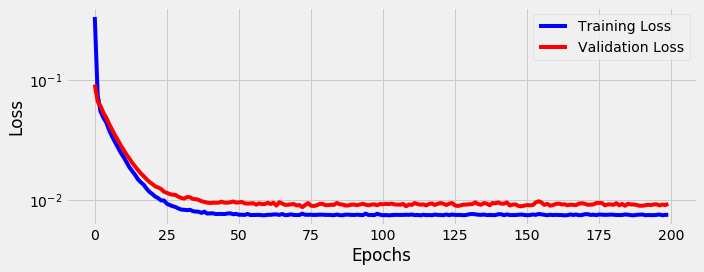

In [45]:
fig = plot_losses(losses, val_losses)

# TensorBoard

TensorBoard is a very useful visualization tool from PyTorch’s competing framework, Tensorflow. And you can use this with PyTorch as well, which provides classes and methods for us to integrate TensorBoard with our model.

In [46]:
# tensorboard_cleanup()

First, we need to load Tensorboard’s extension for Jupyter:

In [76]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Then, we run Tensorboard using the newly available magic:

In [78]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 7536), started 0:01:09 ago. (Use '!kill 7536' to kill it.)

The magic above tells TensorBoard to look for logs inside the folder specified by the logdir argument: runs. So, in this case, there must be a runs folder in the same location as the notebook you are using to train the model. To make things easier for you, the runs folder was already created beforehand, so you get it out-of-the-box already.

## SummaryWriter

Learn about what the SummaryWriter class does, and take a look at the functionality of two of its methods: `add_graph` and `add_scalars`.

It all starts with the creation of a SummaryWriter:

In [81]:
writer = SummaryWriter('runs/test')

If we try printing this, we get the following output:

In [82]:
print(writer)

Since we told TensorBoard to look for logs inside the runs folder, it only makes sense to actually log to that folder. 

Moreover, to be able to distinguish between different experiments or models, we should also specify a sub-folder: test.

If we do not specify any folder, TensorBoard will default to `runs/CURRENT_DATETIME_HOSTNAME`, which is not such a great name if you are looking for your experiment results in the future.

So, it is recommended to try to name it in a more meaningful way like `runs/test` or `runs/simple_linear_regression`. It will then create a subfolder inside runs (the folder we specified when we started TensorBoard).

Even better, you should name it in a meaningful way, and add DateTime or a sequential number as a suffix like `runs/test_001` or `runs/test_20200502172130` to avoid writing data of multiple runs into the same folder (we will see why this is bad in the add_scalars section below).

## Methods

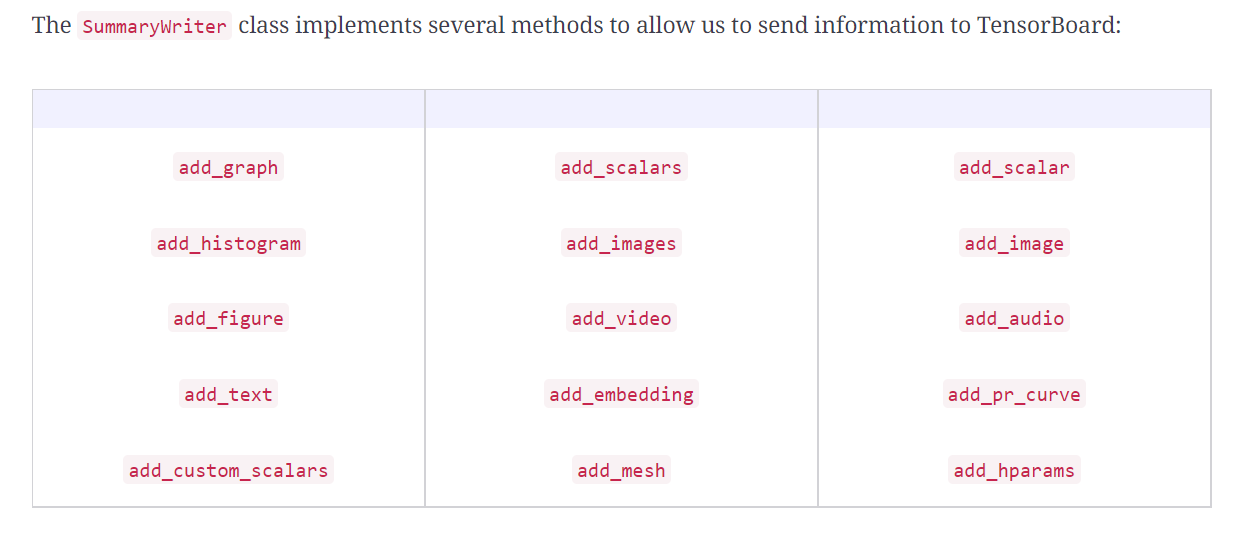

It also implements two other methods for effectively writing data to disk:

- `flush`
- `close`

We will be using the first two methods, add_graph and add_scalars, to send our model’s graph and, of course, both scalars: training and validation losses. This will be slightly different from the same as the Dynamic Computation Graph we drew using make_dot.

## add_graph

In [83]:
writer.add_graph(model)

TypeError: 'NoneType' object is not iterable

So, we need to send some inputs together with our model. Let us fetch a mini-batch of data points from our train_loader, and then pass it as input to add_graph:

In [85]:
# Fetching a tuple of feature (sample_x) and label (sample_y)
sample_x, sample_y = next(iter(train_loader))

# Since our model was sent to device, we need to do the same with the data
# Even here, both model and data need to be on the same device!
writer.add_graph(model, sample_x.to(device))

Rerunning `%tensorboard`...

In [86]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 7536), started 0:11:17 ago. (Use '!kill 7536' to kill it.)

## add_scalars

What about sending the loss values to TensorBoard? We can use the add_scalars method to send multiple scalar values at once, which requires the following three arguments:

- **main_tag**: The parent name of the tags or the “group tag,” if you will.

- **tag_scalar_dict**: The dictionary containing the `key: value` pairs for the scalars you want to keep track of. In our case, **training and validation losses**.

- **global_step**: Step value or **the index** you are associating with the values you are sending in the dictionary. The epoch comes to mind in our case, as losses are computed for each epoch.

How does it translate into code? Let’s check it out:

In [87]:
writer.add_scalars('loss', {'training': loss, 'validation': val_loss}, epoch)

In [98]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 7536), started 0:18:23 ago. (Use '!kill 7536' to kill it.)

### Model Configuration V3

Not very useful, eh? We need to incorporate these elements into our model configuration and model training codes.

The updated model configuration code looks like the following:

In [90]:
%run -i Scripts/data_preparation/v2.py

In [92]:
%%writefile Scripts/model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

Overwriting Scripts/model_configuration/v3.py


In [93]:
%run -i Scripts/model_configuration/v3.py

### Model Training V5

The updated model training code looks similar to the following:

In [94]:
%%writefile Scripts/model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under the main tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training': loss, 'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

Writing Scripts/model_training/v5.py


In [96]:
%run -i Scripts/model_training/v5.py

In [97]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


# Saving and Loading Models

Training a model successfully is great. There’s no doubt about that, but not all models will be trained that fast and maybe training gets interrupted (computer crashing, timeout after 12h of continuous GPU usage on Google Colab, etc.). It would be a pity to have to start over, right?

So, it is important to be able to **checkpoint** or save our model; that is, saving it to disk in case we would like to restart training later or deploy it as an application to make predictions.

### Model state

To checkpoint a model, we basically have to save its state to a file so that it can be loaded back later, nothing special, actually.

But, what actually defines the state of a model? The following provides an overview of this:

- `model.state_dict()`: Kinda obvious, right?

- `optimizer.state_dict()`: Remember, optimizers have a state_dict as well.

- **Losses**: After all, you should keep track of its evolution.

- **Epoch**: It is just a number, so why not?

- Anything else you’d like to have restored later.

## Saving

After defining the model state, we now have to wrap everything into a Python dictionary, and use torch.save() to dump it all into a file. Easy peasy! We have just saved our model to a file named model_checkpoint.pth.

In [99]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses,
              'val_loss': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

The procedure is exactly the same if you are checkpointing a partially trained model to resume training later or if you are saving a fully trained model to deploy it and make predictions.

Okay, what about loading it back? In that case, it will be a bit different depending on what you are doing.

## Resuming Training

If we are starting fresh (as if we had just turned on the computer and started Jupyter), we have to set up the stage before actually loading the model. This means we need to load the data and configure the model.

Luckily, we have the code for that already: **data preparation V2** and **model configuration V3**.

In [101]:
%run -i Scripts/data_preparation/v2.py
%run -i Scripts/model_configuration/v3.py

In [103]:
# Untrained model...
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


#### Resuming...

Now we are ready to load the model back, which is easy:

- Load the dictionary back using `torch.load()`.

- Load model and optimizer state dictionaries back using the `load_state_dict()` method.

- Load everything else into their corresponding variables.

We can verify this by running the following code:

In [104]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

model.train() # always use TRAIN for resuming training

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

Let us inspect the model now:

In [63]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9448]], device='cuda:0')), ('0.bias', tensor([1.0295], device='cuda:0'))])


### Continue with training...

Next, we can run model training V5 to train it for another 200 epochs.

In [106]:
%run -i Scripts/model_training/v5.py

In [107]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


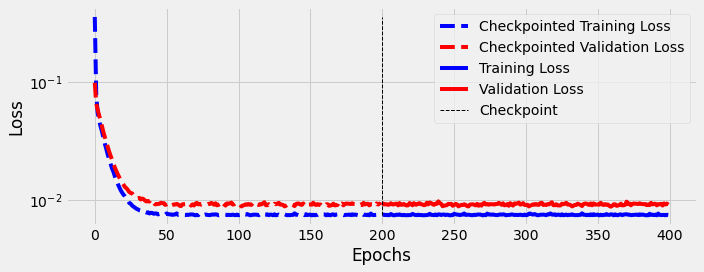

In [108]:
fig = plot_resumed_losses(saved_epoch, saved_losses, saved_val_losses, n_epochs, losses, val_losses)

## Deploying / Making Predictions

#### Using our model for making predictions

Again, if we are starting fresh as if we had just turned on the computer and started Jupyter, we have to set up the stage before actually loading the model. But, this time, we only need to configure the model:

In [110]:
%run -i Scripts/model_configuration/v3.py

<Figure size 432x288 with 0 Axes>

### Retoring back again..

In [111]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


#### Predictions

After recovering our model’s state, we can finally use it to make predictions for new inputs:

In [69]:
new_inputs = torch.tensor([[.20], [.34], [.57]])

model.eval() # always use EVAL for fully trained models!
model(new_inputs.to(device))

tensor([[1.4185],
        [1.6908],
        [2.1381]], device='cuda:0', grad_fn=<AddmmBackward>)

# Putting It All Together

### Data preparation V2

In [112]:
# %load data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

### Model configuration V3

In [113]:
# %load model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

### Model training V5

In [114]:
# %load model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under the main tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training': loss, 'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

And finally, inspecting the model’s state gives us:

In [115]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


### Weird plots in TensorBoard?

Run this if you want to clean up a previous run and start fresh with TensorBoard :-)

In [73]:
import shutil

shutil.rmtree('./runs/simple_linear_regression/', ignore_errors=True)